# Nonparametric Bayesian label prediction on a graph

This script generates the plots and parts of the storyline for the presentation of the doctoral thesis "Nonparametric Bayesian label prediction on a graph" that is comprehensible to non-specialists. It includes an analysis of simulated station traffic data on the Transport for London network (tube, overground, DLR, tramlink). The edges in the network are actual line connections and stations that are within walking distance as per the [TfL network](http://content.tfl.gov.uk/large-print-tube-map.pdf) (May 2019).

* The data folder contains the edge list of the network and station coordinates and zones in .csv format. The Lines.xlsx file contains the edge list in .xlsx format with a separate sheet per line.
* This notebook contains the storyline, plots and example analysis.

In [1]:
import csv  # read station coordinates and zones
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap  # to make custom RAG colormap
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.sparse import diags  # sparse diagonal matrices
from scipy.sparse.linalg import eigsh  # eigendecomposition

## Introduction

My research is about label prediction on a graph. A graph, or network, I encounter or hear about almost every day is the tube in London. This presentation will introduce some of the concepts related to my thesis to give you some idea of its contents.

Let's have a look at the TfL (Transport for London) network. This contains the tube, DLR, cable car, overground, TfL rail and trams:

![TfL map](data/tube-map.gif)

We can also represent the TfL network using a node for each station and connecting the nodes if there is a line, internal interchange or under 10 minutes walk between them.

In [2]:
# The lines files is an edge list of the TfL network
tfl = nx.read_edgelist('data/lines', delimiter='|')
n = nx.number_of_nodes(tfl)  # there are 443 stations

We use the coordinates of each station to make a similar picture as the above map and also load the zone data. We do not use the zone in any further calculations.

In [3]:
# Map the stations to their coordinates and zone using csv file data
coordinates = {}
zones = {}
with open('data/stations.csv') as stations_file:
    station_reader = csv.reader(stations_file, delimiter='|')
    for row in station_reader:
        coordinates[row[0]] = [float(row[1]), float(row[2])]
        zones[row[0]] = row[3]

In [4]:
# We can use a red-amber-green colormap to show how busy each station is 
def rag_colormap():
    rag = LinearSegmentedColormap.from_list('RAG', ['xkcd:green', 'xkcd:amber', 'xkcd:red'])
    return rag

In [5]:
# Fix some plot settings so all network plots have the same format
def plot_network(network, position, color, **kwds):
    rag = rag_colormap()  # use the red-amber-green colormap we defined above
    nx.draw(network, pos=position,
            node_size=75, node_color=color,  # string represting one color, or an array of floats for colormap
            cmap=rag,  # ignored if value is a string
            edge_color='xkcd:light grey',
            vmin=-4, vmax=4,  # the range for the colormap is between these values
            **kwds)

c:\users\merel\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


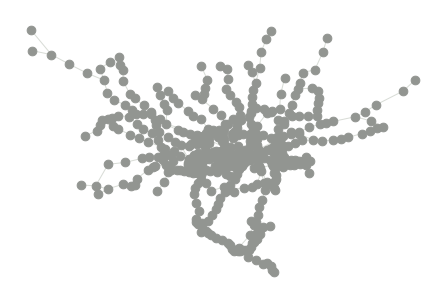

In [6]:
plt.figure()
plot_network(tfl, coordinates, 'xkcd:grey')

One of the features of the TfL network is that it is very busy in peak hours. We represent how crowded a station is on a red-amber-green color scale with red being overcrowded. Let's say we have collected some information about some of the stations in the network.

In [7]:
# Create an example function h0 on the line that we will generalize to a function on the network. We only have a partial, 
# noisy observation z of the true function h0.
x = np.linspace(0, 1, num=n)
h0 = np.sin(12 * (x + 0.2)) / (x + 0.2)  # example true underlying function
noise = np.random.normal(size=n)
z = h0 + noise  # noisy observation

In [8]:
# We remove a fraction p of the observations in y to simulate a partial observation.
def make_missing(y, p):
    n = len(y)
    miss_ix = np.random.choice(n, size=round(p*n), replace=False)
    miss = np.zeros(n, dtype=bool)  # boolean mask to indicate the missing observations
    miss[miss_ix] = True
    y[miss] = None  # the missing observations are represented by None value
    return (y, miss)  # return both the partial observation and the mask for missing observations

In [9]:
z, miss = make_missing(z, 0.5)  # we remove half of the observations

In [10]:
# We use the eigendecomposition of the Laplacian matrix of the graph for function construction and estimation. 
def eigen(network, K):
    L = nx.laplacian_matrix(network)
    lmbda, U = eigsh(L.asfptype(), which='SM', k=K)  # computes the K smallest eigenvalues
    lmbda[0] = lmbda[1]  # replace lmbda[0]=0 by lmbda[1]>0 to make invertible
    return (lmbda, U)

In [11]:
# Use the basis expansion over eigenvectors of the Laplacian matrix of the graph to represent a function on a graph. To 
# generalize the example function h0 to the TfL network, we project the function onto the eigenvectors of the path graph 
# and use the resulting coefficients on the eigenvectors of the TfL network to make an example function on the TfL network. 
P = nx.path_graph(n)
K = 256  # we don't use all eigenvectors to speed up computations
kappa, V = eigen(P, K)  # eigendecomposition of the path graph

In [12]:
lmbda, U = eigen(tfl, K)  # eigendecomposition of the TfL network

In [13]:
g0 = V.T.dot(h0)  # coefficient of projection of true function h0 onto the eigenvectors of the path graph

In [14]:
f0 = U.dot(g0)  # corresponding function on the TfL network
y = f0 + noise  # add noise
y[miss] = None  # make it into a partial observation

c:\users\merel\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


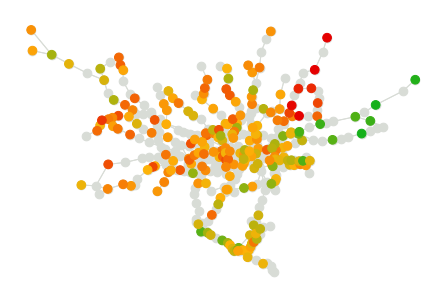

In [15]:
plt.figure()
plot_network(tfl, coordinates, 'xkcd:light grey')
plot_network(tfl, coordinates, y)

We can see that some stations are busy (red) and some stations are quiet (green). For some stations we have no information (light grey) and the information we have might have some measurement errors. In my research, I have developed methods to complete this picture and get rid of the noise. The underlying assumption of these methods is that stations that are close to each other in the network should be about equally busy.

## Scale and frequency

To estimate the correct and full colors on the TfL network we interpret our data as a noisy observation of a signal.

In [16]:
# Fix some plot settings for scatter plots on a path graph.
def scatter_path_graph(ax, x, y, **kwargs):
    ax.scatter(x, y,  marker='.', c='xkcd:black', **kwargs)

In [17]:
# Fix some plot settings for line plots on a path graph.
def plot_path_graph(ax, x, f, color='xkcd:blue', **kwargs):
    ax.plot(x, f, linewidth=2, c=color, **kwargs)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_ylim([-5, 5])

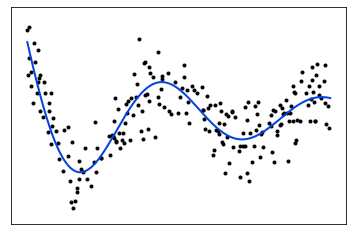

In [18]:
fig, ax = plt.subplots()
scatter_path_graph(ax, x, z)  # noisy data
plot_path_graph(ax, x, h0)  # true signal

In the above picture, we are interested in finding the true signal (blue) from our noisy observations (dots). In our analogy, this picture corresponds to the partially colored picture of the TfL network.

To find the true signal, we try to build it from basic signals. For a function on the line (as above), these basic signals correspond to frequencies.

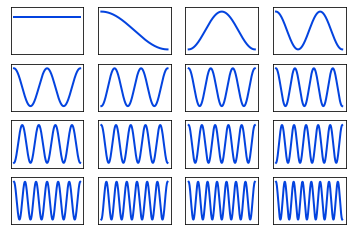

In [19]:
# Plot the first 16 eigenvectors of the path graph.
fig, axs = plt.subplots(4, 4)
axs = axs.flatten()
for k in range(16):
    plot_path_graph(axs[k], x, 4.0 * np.sqrt(0.5 * n) * V[:,k])

As you can see, we start with a simple constant signal. Low frequencies correspond to smooth signals, whereas high frequencies correspond to rough signals. If we include higher frequencies, we can build more complicated functions. On the TfL network, frequecies correspond to how often the signal on the network changes color.

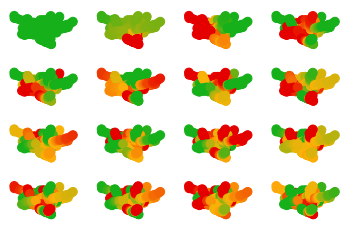

In [20]:
# Plot the first 16 eigenvectors of the TfL network
fig, axs = plt.subplots(4, 4)
axs = axs.flatten()
for k in range(16):
    plot_network(tfl, coordinates, 5 * np.sqrt(n) * U[:,k], ax=axs[k])  # 5*sqrt(n) is just for scale